In [4]:
import time
from tqdm import tqdm
import math
from scipy import special, stats, optimize, fft
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

In [3]:
def g(x, sigma=1):
    return 1/np.sqrt(1*np.pi*sigma**2) * np.exp(-1/2 * x**2 / sigma**2)

In [4]:
def roll_middle(arr):
    return np.roll(arr, int(len(arr)/2))

In [5]:
def fourier_fast(x):
    N = len(x)
    n = np.arange(N)
    # k = n.reshape((N, 1))
    e = np.exp(2j * np.pi * n.reshape((N, 1)) * n / N)
    # print(e)
    # print(e.shape)
    return np.dot(e, x)


def inverse_fourier_fast(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    # print(e)
    # print(e.shape)
    return np.dot(e, x)/N

def fourier_basic(x):
    N = len(x) + 1
    coeffs = np.empty((N-1, N-1))
    for n in range(N-1):
        coeffs[n, :] = np.exp(-2j * np.pi * n * np.arange(N-1) / (N-1))
    return np.dot(coeffs, x)*delta


## Kako gaussa naredimo periodicnega za Fouriera

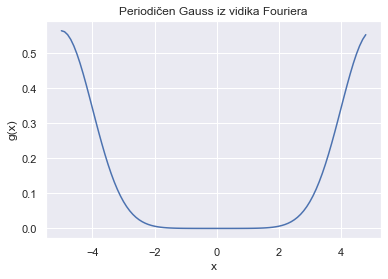

/var/folders/m8/9l49w63s671c8spdcmv30q_40000gn/T/ipykernel_50627/3022226346.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs[n, :] = np.exp(-2j * np.pi * n * np.arange(N-1) / (N-1))


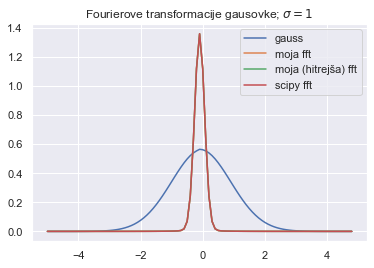

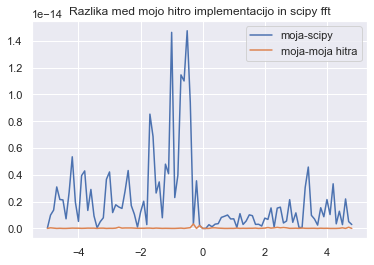

In [52]:
N = 100
x0 = -5
x1 = 5
L = x1-x0
delta = np.abs(x1-x0)/N
x = np.linspace(x0, x1, num=N, endpoint=False)
g_k = g(x)
g_k = roll_middle(g_k)[:-1]

plt.plot(x[:-1],g_k)
plt.title("Periodičen Gauss iz vidika Fouriera")
plt.xlabel("x")
plt.ylabel("g(x)")
plt.savefig("grafi/trans_gauss.pdf", bbox_inches='tight')
plt.show()

Hns = fourier_basic(g_k)

y_four = fft.fft(g_k)*delta

y_four_dis = fourier_fast(g_k)*delta

plt.plot(x[:-1], roll_middle(g_k), label='gauss')
plt.plot(x[:-1], roll_middle(Hns.real), label='moja fft')
plt.plot(x[:-1], roll_middle(y_four_dis.real), label='moja (hitrejša) fft')
plt.plot(x[:-1], roll_middle(y_four.real), label='scipy fft')

plt.title("Fourierove transformacije gausovke; $\sigma = 1$")
plt.legend()
plt.savefig("grafi/fourier_gausovke.pdf", bbox_inches='tight')
plt.show()


plt.title("Razlika med mojo hitro implementacijo in scipy fft")
plt.plot(x[:-1], np.abs(roll_middle(Hns.real-y_four.real)), label='moja-scipy')
plt.plot(x[:-1], np.abs(roll_middle(Hns.real-y_four_dis.real)), label='moja-moja hitra')
plt.legend()
plt.savefig("grafi/fourier_gausovke_razlika.pdf", bbox_inches='tight')
plt.show()


Mogoče nepomemben komentar vendar sem se nekaj ur ukvarjal s tem, da se ugotovil, da je pravilen člen v fourierjovi transformaciji, da vzamem $N-1$ in ne $N$ (odvisno od implementacije, vendar je zares težko opaziti razliko).

Napisal sem dve različni implementaciji. Najprej sem napisal osnovno verzijo, ki uporablja zanke v pythonu, kar je seveda (relativno) izjemno počasi. Nato sem napisal še verzijo, ki je popolnoma vektorska; generira matriko koeficientov za fourierove transformacije potem pa jo zmnoži z vektorjem vrednosti funkcije. To nam seveda poda vektor $H_k$ fourierove transformacije.

Na grafu \ref{} lahko opazimo, da se vse metode praktično sovpadajo, moji implementaciji še malenkost bolj ker sta seveda v principu enaki. Vprašanje na mestu je, zakaj bi sploh uporabljal osnovno (ne vektorsko) verzijo FT. Za zelo velike matrike, je precej boljše vzeti horizontalen scaling, ker nam to ne zasede rama (lahko bi napisal še eno verzijo, kjer je tudi množenje vektorjev napisano na roke, vendar bi to imeli druga ozka grla - Python for zanke...).

hmm... kaj se zgodi ce ne rollas

/Users/greg/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


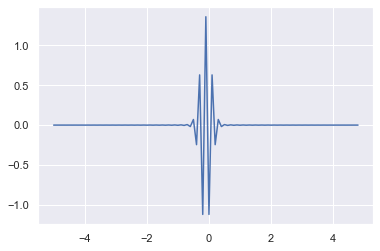

In [53]:
y = fourier_fast(roll_middle(g_k))
plt.plot(x[:-1], roll_middle(y*delta))
plt.savefig("grafi/gaus_.pdf", bbox_inches='tight')
plt.show()

Če funkcije ne naredimo periodične (oziroma jo naredimo napačno periodično), dobimo močno modulacijo kot fourierovo transformacijo. Zato je potrebna periodičnost ali pa dodamo modulacijski faktor $\exp (2\pi i \nu T (N/2))$.

## Razlika med inverzom fouriera in gausovko

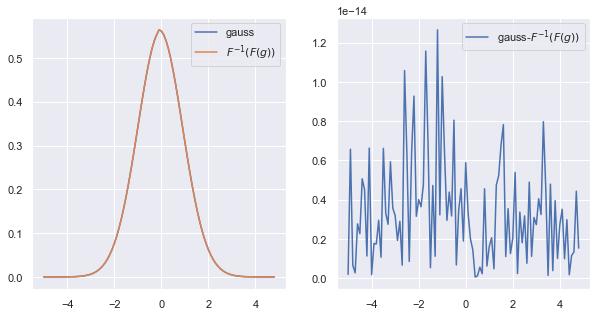

In [54]:
y_inverz = inverse_fourier_fast(fourier_fast(g_k))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1, ax2 = axes
ax1.plot(x[:-1], roll_middle(g_k), label='gauss')
ax1.plot(x[: -1], roll_middle(y_inverz.real), label='$F^{-1}(F(g))$')
ax1.legend()
ax2.plot(x[:-1], np.abs(roll_middle(g_k-y_inverz.real)), label='gauss-$F^{-1}(F(g))$')
ax2.legend()
plt.savefig("grafi/inverse_gauss_napaka.pdf", bbox_inches='tight')
plt.show()

## Cas racunanja

In [46]:
x0 = -5
x1 = 5
L = x1-x0

N1 = 10
N2 = 2000


scipy_times, moja_times = np.empty((N2-N1, 2)).T


for n in tqdm(range(N1, N2)):
    delta = np.abs(x1-x0)/n
    x = np.linspace(x0, x1, num=n, endpoint=False)
    g_k = roll_middle(g(x))[:-1]

    start = time.time()
    y_four = fft.fft(g_k)*delta
    scipy_times[n-N1] = time.time() - start

    start = time.time()
    y_four_dis = fourier_basic(g_k)*delta
    moja_times[n-N1] = time.time() - start


  0%|          | 0/1990 [00:00<?, ?it/s]/var/folders/m8/9l49w63s671c8spdcmv30q_40000gn/T/ipykernel_50627/3022226346.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs[n, :] = np.exp(-2j * np.pi * n * np.arange(N-1) / (N-1))
100%|██████████| 1990/1990 [01:44<00:00, 19.10it/s]


In [47]:
def lin_fit(x,a,b):
    return a*x + b

def xlogx(x,a,b):
    return a*x*np.log(x) + b

def x_2(x,a,b):
    return a*x**2 + b

[  1.8094235  -15.69671077] [ 0.00729937 -0.43287471]


/var/folders/m8/9l49w63s671c8spdcmv30q_40000gn/T/ipykernel_50627/1393481534.py:16: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x), np.log(moja_times), label='moja fft')


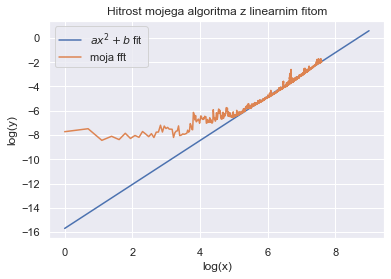

In [67]:
# nadaljevanje prejsne

skip_first = 150

x = np.arange(len(moja_times))
# popt, pcov = optimize.curve_fit(lin_fit, np.log(np.arange(len(moja_times))[10:]), np.log(moja_times[10:]))
popt, pcov = optimize.curve_fit(lin_fit, np.log(
    x[skip_first:]), np.log(moja_times[skip_first:]))
perr = np.sqrt(np.diag(pcov))

print(popt, perr*popt)

# plt.plot(np.log(x),np.log(scipy_times), label='scipy fft')
plt.plot(x[:10], lin_fit(x[:10], popt[0], popt[1]), label='$ax^2+b$ fit')

plt.plot(np.log(x), np.log(moja_times), label='moja fft')
# plt.plot(np.log(x), np.log(x_2(x,1,1)), label='moja fft')
plt.title("Hitrost mojega algoritma z linearnim fitom")
plt.legend()
plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.savefig("grafi/casovna_zahtevnost.pdf", bbox_inches='tight')
# plt.yscale('log')
plt.show()


S fitom na grafu \ref{} opazimo, da je koeficient časovne zahtevnosti $x^{\alpha} = x^{1,81}$, $b = -15,7$. Prvih nekaj meritev ni najbolj relevantnih, ker ne gre za ozko grlo pri številu meritev, vendar je nek konstanten čas za procesiranje števil meritev. Verjetno bi bilo smiselno narisati še nekaj meritev več točk, vendar mislim, da moj računalnik tega žal nebi zmogel.

Opazimo lahko, da ima moj algoritem malce manj kot kvadratno ćasovno zahtevnost, kar bi lahko razbral že iz same kode. Da je zahtevnost zares skoraj kvadratna nam ponazarja že to, da pred končnim izračunom za največji $N$ dobimo matriko $N \times N$, ki jo pomnožimo z vektorjem.

Zanimivo mi je tudi, da je algoritem scipy tako zelo hitrejši, čeprav je moj v celoti zgrajen z numpy vektorji in matrikami. To pomeni, da tudi s tako optimizacijo ni možno doseči optimizacijo Cja.

Primerjava med mojimi

In [56]:
# x0 = -5
# x1 = 5
# L = x1-x0

# N1 = 10
# N2 = 400


# scipy_times, moja_times = np.empty((N2-N1, 2)).T


# for n in tqdm(range(N1, N2)):
#     delta = np.abs(x1-x0)/n
#     x = np.linspace(x0, x1, num=n, endpoint=False)
#     g_k = roll_middle(g(x))[:-1]

#     start = time.time()
#     coeffs = np.empty((n-1, n-1))
#     for i in range(n-1):
#         coeffs[i, :] = np.exp(-2j * np.pi * i * np.arange(n-1) / (n-1))
#     Hns = np.dot(coeffs, g_k)*delta
#     scipy_times[n-N1] = time.time() - start

#     start = time.time()
#     y_four_dis = fourier_fast(g_k)*delta
#     moja_times[n-N1] = time.time() - start

# # nadaljevanje prejsne

# popt, pcov = optimize.curve_fit(x_2, np.arange(len(moja_times)), moja_times)
# x = np.arange(len(moja_times))

# print(popt)

# plt.plot(scipy_times, label='scipy fft')
# plt.plot(x[:], x_2(x[:], popt[0], popt[1]), label='$ax^2+b$ fit')

# plt.plot(moja_times, label='moja fft')
# plt.title("Vbistvu je isti algoritem")
# plt.legend()
# plt.savefig("grafi/algoritmi hitrost.pdf", bbox_inches='tight')
# # plt.yscale('log')
# plt.show()


## Ostale random funkcije

In [58]:
def f1(x):
    return 1.3*np.sin(2*np.pi*2*x) + 0.5*np.sin(2*np.pi*1.2*x)# - np.cos(2*np.pi*2.1*x) - 0.5*np.sin(2*np.pi*x)


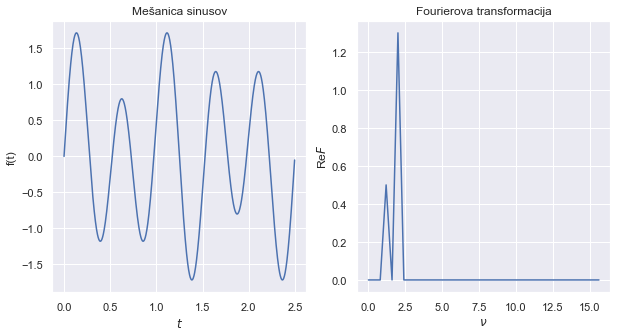

In [59]:
N = 500*2
x0 = 0
x1 = 2.5
delta = (x1-x0)/N
rate = 1/delta

x = np.linspace(x0,x1, num=N, endpoint=False)

freqs = np.linspace(0.0, int(rate/2), int(N/2))
freqs_y = fourier_fast(f1(x))
# ker itak dobimo simetricno
y = 2/N * np.abs(freqs_y[0:int(N/2)])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1, ax2 = axes
ax1.plot(x,f1(x))
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"f(t)")
ax1.set_title("Mešanica sinusov")

ax2.plot(freqs[:40], y.real[:40])
ax2.set_xlabel(r"$\nu$")
ax2.set_ylabel(r"Re$F$")
ax2.set_title("Fourierova transformacija")
plt.savefig("grafi/fourier_sinusov.pdf", bbox_inches='tight')
plt.show()


Opazimo lahko, da nam FT vrne pravilne frekvence in amplitude. Narisal sem funkcijo
$$
1.3\sin(2 \pi 2 t) + 1.5\sin(2 \pi 1.2 t)
$$

## Leaking

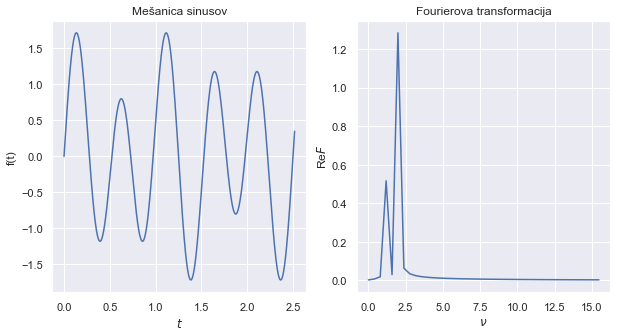

In [60]:
N = 500*2
x0 = 0
x1 = 2.52
delta = (x1-x0)/N
rate = 1/delta

x = np.linspace(x0, x1, num=N, endpoint=False)

freqs = np.linspace(0.0, int(rate/2), int(N/2))
freqs_y = fourier_fast(f1(x))
# ker itak dobimo simetricno
y = 2/N * np.abs(freqs_y[0:int(N/2)])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1, ax2 = axes
ax1.plot(x, f1(x))
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"f(t)")
ax1.set_title("Mešanica sinusov")

ax2.plot(freqs[:40], y.real[:40])
ax2.set_xlabel(r"$\nu$")
ax2.set_ylabel(r"Re$F$")
ax2.set_title("Fourierova transformacija")
plt.savefig("grafi/fourier_puscanje.pdf", bbox_inches='tight')
plt.show()


Zdaj lahko še enkrat isto funkcijo narišemo na malce večje definicijsko območje (iz 2,5 na 2,52; fino je malo pretirati, da se zares dobro opazi puščanje - enak pojav je tudi, če vključimo zgolj točko 2.5, vendar ni tako izrazit). Kar vidimo je, da je puščanje zares prisotno.

## Obdelava primerov iz spletne

In [62]:
bach_882 = np.loadtxt('./bach/Bach.882.txt')
bach_1378 = np.loadtxt('./bach/Bach.1378.txt')
bach_2756 = np.loadtxt('./bach/Bach.2756.txt')
bach_5512 = np.loadtxt('./bach/Bach.5512.txt')
bach_11025 = np.loadtxt('./bach/Bach.11025.txt')
bach_44100 = np.loadtxt('./bach/Bach.44100.txt')

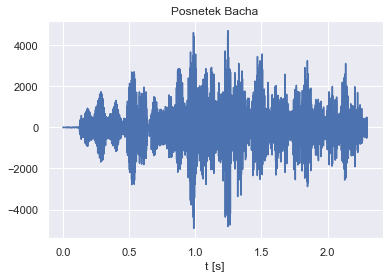

In [64]:
x = np.linspace(0, 2.3, num=len(bach_882))
plt.plot(x,bach_882)
plt.xlabel('t [s]')
plt.title("Posnetek Bacha")
plt.savefig("grafi/posnetek.pdf", bbox_inches='tight')
plt.show()


In [ ]:
from joblib import Parallel, delayed

def fourier_basic_threaded(x, delta):
    N = len(x) + 1
    # Hns = np.empty(N-1)

    def Hn(n):
        return np.sum(np.exp(-2j * np.pi * n * np.arange(N-1) / (N-1)) * x) * delta

    # for n in range(N-1):
    #     Hns[n] = Hn(n)
    # return Hns

    return Parallel(n_jobs=24)(delayed(Hn)(n) for n in range(N-1))

    # with Pool(5) as p:
    #     print(p.map(Hnn, range(N-1)))
    # for n in range(N-1):
    #     Hns[n] = Hn(n)
        # return Hns
    # return np.dot(coeffs, x)*delta

100%|██████████| 6/6 [00:00<00:00, 12.74it/s]


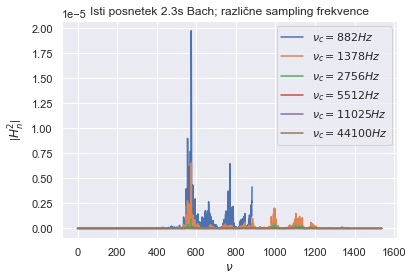

In [65]:
frequencies = [882,1378,2756,5512,11025,44100]

for freq in tqdm(frequencies):
    sig = np.loadtxt(f'./bach/Bach.{freq}.txt')
    t0 = 0
    t1 = 2.3
    rate = freq*2

    N = len(sig)

    delta = 1/rate
    freqs = np.linspace(0.0, int(rate/2), int(N/2))
    x = np.linspace(t0,t1,num=N)

    # freqs_y = fourier_basic_threaded(sig ,delta)
    freqs_y = fft.fft(sig)
    # ker itak dobimo simetricno
    y = 2/N * np.abs(freqs_y[0:int(N/2)])

    # plt.plot(x, sig)
    plt.plot(freqs[:2000], y[:2000]**2/N*delta**2, label=fr'$\nu_c = {freq}Hz$')

plt.legend()
plt.title("Isti posnetek 2.3s Bach; različne sampling frekvence")
plt.xlabel(r"$\nu$")
plt.ylabel('|$H_n^2$|')
plt.savefig("grafi/analiza_bacha.pdf", bbox_inches='tight')
plt.show()


To bo trajal forever -> grem probat prepisat fouriera z multiprocessingom.

Ugotovil sem, da je funkcija preveč počasna, da bi izračunal sampling pri 44kHz. Zato sem jo še enkrat prepisal s paralelno prijazno kodo. Postavil sem, da naenkrat uporablja vsda jedra v mojem računalniku. Tako je 2 minuti in pol Python uporabljal 100% CPU (vseh 8 jeder) in 100% RAMa. Brez te optimizacije se je koda poganjala 15 minut in še ni izračunal, kar je precej slabše. Še vedno pa je Scipy Fourier precej boljši, ker je za isti izračun porabil zgolj nekaj sekund, vendar seveda z C kodo pač nemoremo tekmovati v Pythonu.

Na grafu je nekaj zanimivih razlik med različnimi sampli. Seveda se frekvenčno območje poveča pri večjih samplih (po definiciji) vendar sem vse narisal na območje zgoraj omejeno na 2000 Hz. Tako je območje precej bolj pregledno (če narišem 44kHz se vidi samo največji sample). Pri večjih $\nu_c$ so posamezne bolj ostre in nižje (ker je frekvenčno območje večje). Ta razlika je zelo očitna na mp3 posnetkih. Pri nijih sample ratih od 44kHz se praktično ne sliši da gre za violino, ker je zvok popolnoma pridušen.

## Kje so vrhovi?

555Hz, 563Hz, 563Hz, 573Hz, 574Hz, 989Hz, 993Hz, 995Hz, 997Hz, 1102Hz


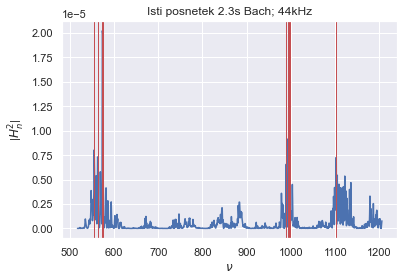

In [68]:
sort_arr = y.argsort()
max_freqs = freqs[sort_arr][-10:][::-1]

print(", ".join([str(x)+'Hz' for x in np.sort(np.int64(max_freqs))]))

plt.plot(freqs[523+150:1318+250], y[523+150:1318+250]**2/N*delta)
for fr in max_freqs:
    plt.axvline(x=fr, color='r', linewidth='1')
plt.title("Isti posnetek 2.3s Bach; 44kHz")
plt.xlabel(r"$\nu$")
plt.ylabel('|$H_n^2$|')
plt.savefig("grafi/bach_frekvence.pdf", bbox_inches='tight')
plt.show()


Frekvence so seveda odvisne od tega kako oglasimo violino, vendar se lahko vseeno omejimo na območje C5 (523 Hz) do E6 (1318 Hz).

Najbolj pogosti toni so (po vrsti):

    \item C#5
    \item D5
    \item B5
    \item C#6


## Dodatna

In [72]:
poskus1 = np.loadtxt('./dodatna/poskus1_akres_novi.dat')


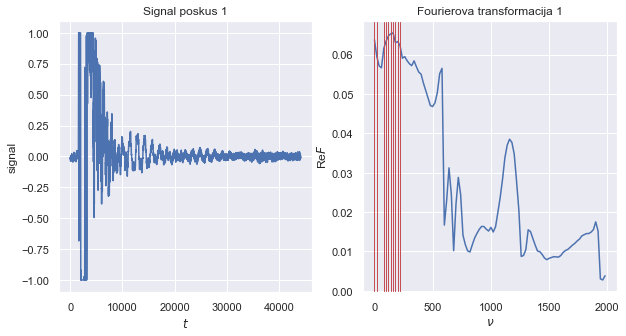

0Hz, 20Hz, 80Hz, 100Hz, 120Hz, 140Hz, 160Hz, 180Hz, 200Hz, 220Hz


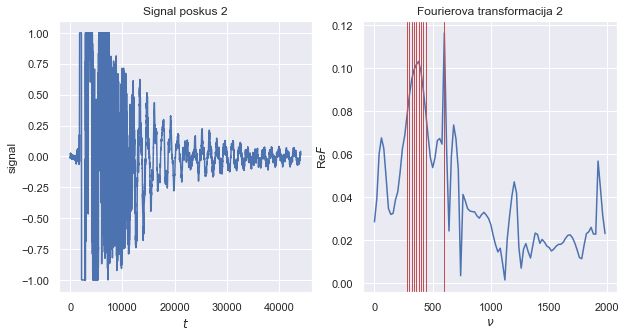

280Hz, 300Hz, 320Hz, 340Hz, 360Hz, 380Hz, 400Hz, 420Hz, 440Hz, 600Hz


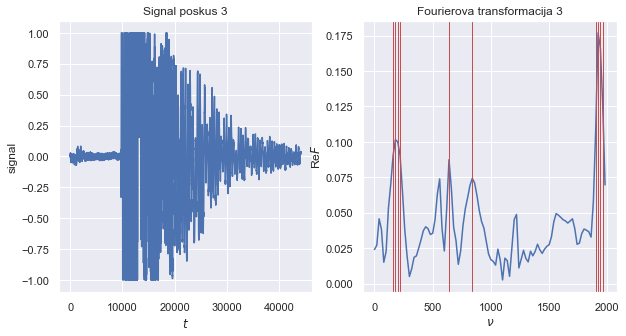

160Hz, 180Hz, 200Hz, 220Hz, 640Hz, 840Hz, 1900Hz, 1920Hz, 1940Hz, 1960Hz


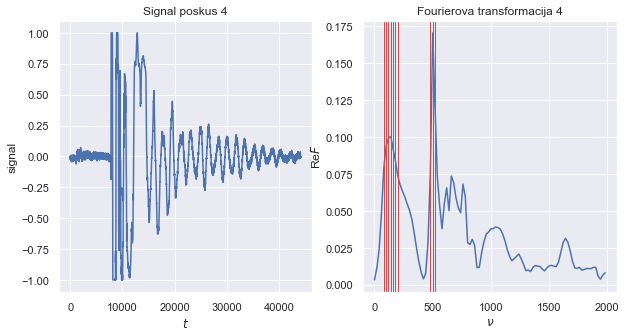

80Hz, 100Hz, 120Hz, 140Hz, 160Hz, 180Hz, 200Hz, 480Hz, 500Hz, 520Hz


In [5]:
freq = 441000
rate = freq*2

# sig = poskus1

for i in range(1,5):
    sig = np.loadtxt(f'./dodatna/poskus{i}_akres_novi.dat')

    N = len(sig)

    delta = 1/freq
    freqs = np.linspace(0.0, freq, int(N/2))


    # freqs_y = fourier_basic_threaded(sig ,delta)
    freqs_y = fft.fft(sig)
    # ker itak dobimo simetricno
    y = 2/N * np.abs(freqs_y[0:int(N/2)])

    # plt.plot(freqs[:1000], y[:1000])

    sort_arr = y.argsort()
    max_freqs = freqs[sort_arr][-10:][::-1]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax1, ax2 = axes
    ax1.plot(sig)
    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"signal")
    ax1.set_title(f"Signal poskus {i}")

    ax2.plot(freqs[:100], y[:100])
    ax2.set_xlabel(r"$\nu$")
    ax2.set_ylabel(r"Re$F$")
    ax2.set_title(f"Fourierova transformacija {i}")
    for fr in max_freqs:
        plt.axvline(x=fr, color='r', linewidth='1')
    plt.savefig(f"grafi/akusticni_poskus_{i}.pdf", bbox_inches='tight')
    plt.show()

    print(", ".join([str(x)+'Hz' for x in np.sort(np.int64(max_freqs))]))
